In [1]:
import json
import re

from catboost import CatBoostRegressor
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from lightgbm import log_evaluation, LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor, plot_importance

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

# Data Preparation

In [2]:
df_eco = pd.read_csv("dataset/economy.csv", thousands=',')
df_biz = pd.read_csv("dataset/business.csv", thousands=',')

In [3]:
df_eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        206774 non-null  object
 1   airline     206774 non-null  object
 2   ch_code     206774 non-null  object
 3   num_code    206774 non-null  int64 
 4   dep_time    206774 non-null  object
 5   from        206774 non-null  object
 6   time_taken  206774 non-null  object
 7   stop        206774 non-null  object
 8   arr_time    206774 non-null  object
 9   to          206774 non-null  object
 10  price       206774 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 17.4+ MB


In [4]:
df_biz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        93487 non-null  object
 1   airline     93487 non-null  object
 2   ch_code     93487 non-null  object
 3   num_code    93487 non-null  int64 
 4   dep_time    93487 non-null  object
 5   from        93487 non-null  object
 6   time_taken  93487 non-null  object
 7   stop        93487 non-null  object
 8   arr_time    93487 non-null  object
 9   to          93487 non-null  object
 10  price       93487 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 7.8+ MB


In [5]:
df_eco.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,5953
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,5953
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,5956
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,5955
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,5955


In [6]:
def rename_columns(df):
    df.rename(
        columns={
            "from": "source_city",
            "to": "destination_city",
            "dep_time": "departure_time",
            "arr_time": "arrival_time"
        },
        inplace=True
    )

In [7]:
def create_days_left_feature(df):
    df.date = pd.to_datetime(df.date, format="%d-%m-%Y")
    booking_date = df.date.min() - pd.Timedelta(days=1)

    df["days_left"] = (df.date - booking_date).dt.days

In [8]:
def create_flight_feature(df):
    df["flight"] = df_eco.ch_code + "-" + df_eco.num_code.astype(str)

    return df

In [9]:
def create_departure_feature(df):
    cols = ["departure_time_hr", "departure_time_min"]

    df[cols] = df.departure_time.str.split(":", expand=True)
    df[cols] = df[cols].astype(np.int64)

In [10]:
def create_arrival_feature(df):
    cols = ["arrival_time_hr", "arrival_time_min"]

    df[cols] = df.arrival_time.str.split(":", expand=True)
    df[cols] = df[cols].astype(np.int64)

In [11]:
def create_duration_feature(df):
    def transform_time_taken(item):
        hour, minute = re.search("([\d.]*)h ([\d.]*)m", item).groups()

        return float(minute or 0) + float(hour or 0) * 60

    df["duration"] = df.time_taken.apply(transform_time_taken)

In [12]:
def create_via_feature(df):
    stops = []
    via_list = []

    for item in df.stop:
        item = re.sub("[\n\t]+", " ", item)
        stop, via = re.search("([\w+-]+)(?: Via (\w+))?", item).groups()

        if not via:
            via = "UNK"

        stops.append(stop)
        via_list.append(via)

    df["stops"] = pd.Series(stops)
    df["via"] = pd.Series(via_list)

In [13]:
def create_class_feature(df, class_):
    df["class"] = class_

In [14]:
df_eco_t = df_eco.copy()

rename_columns(df_eco_t)
create_days_left_feature(df_eco_t)
create_flight_feature(df_eco_t)
create_departure_feature(df_eco_t)
create_arrival_feature(df_eco_t)
create_duration_feature(df_eco_t)
create_via_feature(df_eco_t)
create_class_feature(df_eco_t, "Economy")

df_eco_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                206774 non-null  datetime64[ns]
 1   airline             206774 non-null  object        
 2   ch_code             206774 non-null  object        
 3   num_code            206774 non-null  int64         
 4   departure_time      206774 non-null  object        
 5   source_city         206774 non-null  object        
 6   time_taken          206774 non-null  object        
 7   stop                206774 non-null  object        
 8   arrival_time        206774 non-null  object        
 9   destination_city    206774 non-null  object        
 10  price               206774 non-null  int64         
 11  days_left           206774 non-null  int64         
 12  flight              206774 non-null  object        
 13  departure_time_hr   206774 no

In [15]:
df_biz_t = df_biz.copy()

rename_columns(df_biz_t)
create_days_left_feature(df_biz_t)
create_flight_feature(df_biz_t)
create_departure_feature(df_biz_t)
create_arrival_feature(df_biz_t)
create_duration_feature(df_biz_t)
create_via_feature(df_biz_t)
create_class_feature(df_biz_t, "Business")

df_biz_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                93487 non-null  datetime64[ns]
 1   airline             93487 non-null  object        
 2   ch_code             93487 non-null  object        
 3   num_code            93487 non-null  int64         
 4   departure_time      93487 non-null  object        
 5   source_city         93487 non-null  object        
 6   time_taken          93487 non-null  object        
 7   stop                93487 non-null  object        
 8   arrival_time        93487 non-null  object        
 9   destination_city    93487 non-null  object        
 10  price               93487 non-null  int64         
 11  days_left           93487 non-null  int64         
 12  flight              93487 non-null  object        
 13  departure_time_hr   93487 non-null  int64     

In [16]:
df = pd.concat([df_eco_t, df_biz_t])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300261 entries, 0 to 93486
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                300261 non-null  datetime64[ns]
 1   airline             300261 non-null  object        
 2   ch_code             300261 non-null  object        
 3   num_code            300261 non-null  int64         
 4   departure_time      300261 non-null  object        
 5   source_city         300261 non-null  object        
 6   time_taken          300261 non-null  object        
 7   stop                300261 non-null  object        
 8   arrival_time        300261 non-null  object        
 9   destination_city    300261 non-null  object        
 10  price               300261 non-null  int64         
 11  days_left           300261 non-null  int64         
 12  flight              300261 non-null  object        
 13  departure_time_hr   300261 non-null

# EDA

In [18]:
# Exclude ch_code, num_code, time_taken, departure_time, arrival_time, stop

categorical_features = [
    "date",
    "airline",
    "flight",
    "source_city",
    "destination_city",
    "stops",
    "via",
    "class"
]

numerical_features = [
    "days_left",
    "departure_time_hr",
    "departure_time_min",
    "arrival_time_hr",
    "arrival_time_min",
    "duration",
]

features = categorical_features + numerical_features
target = "price"

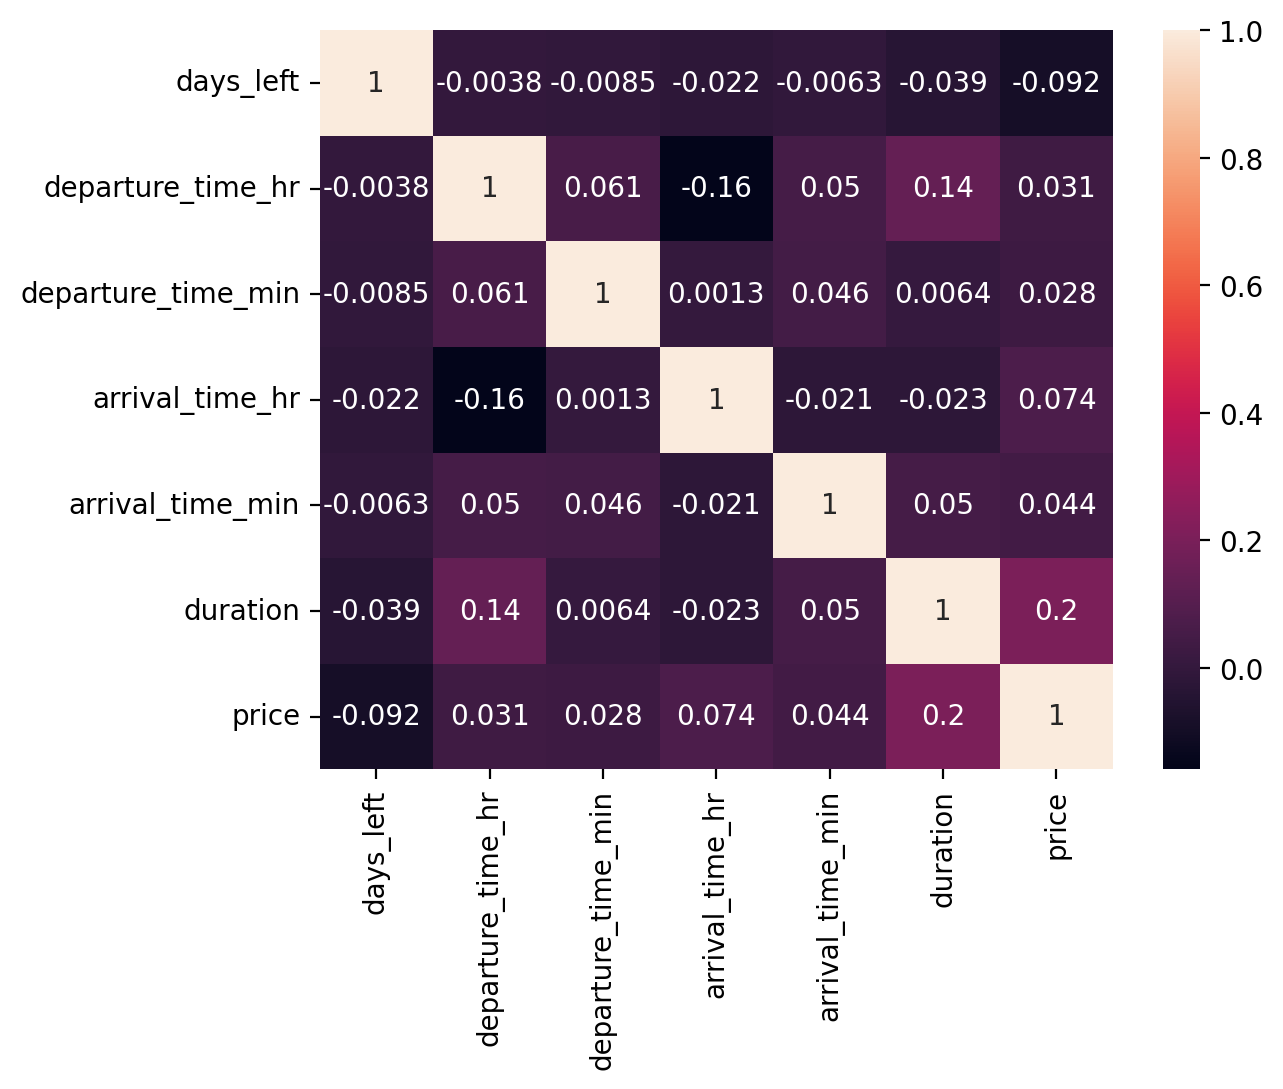

In [19]:
sns.heatmap(df[numerical_features + [target]].corr(), annot=True)
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != target],
    df[target]
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [21]:
print(X_train.shape)
print(y_train.shape)
print()

print(X_val.shape)
print(y_val.shape)
print()

print(X_test.shape)
print(y_test.shape)

(202675, 20)
(202675,)

(22520, 20)
(22520,)

(75066, 20)
(75066,)


In [22]:
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train_cat = oe.fit_transform(X_train[categorical_features])
X_val_cat = oe.transform(X_val[categorical_features])
X_test_cat = oe.transform(X_test[categorical_features])

In [23]:
# Combine categorical and numerical features column-wise
X_train_mat = np.hstack((X_train_cat, X_train[numerical_features]))
X_val_mat = np.hstack((X_val_cat, X_val[numerical_features]))
X_test_mat = np.hstack((X_test_cat, X_test[numerical_features]))

In [24]:
mm = MinMaxScaler()

X_train_scaled = mm.fit_transform(X_train_mat)
X_val_scaled = mm.transform(X_val_mat)
X_test_scaled = mm.transform(X_test_mat)

y_train_scaled = np.log1p(y_train)
y_val_scaled = np.log1p(y_val)
y_test_scaled = np.log1p(y_test)

# Modelling

In [25]:
def reg_scores(y_test, y_pred):
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

def evaluate(model):
    y_pred_val = model.predict(X_val_scaled)
    y_pred_test = model.predict(X_test_scaled)

    val_mse = mean_squared_error(y_val_scaled, y_pred_val)
    test_mse = mean_squared_error(y_test_scaled, y_pred_test)

    y_pred_test_actual = np.expm1(model.predict(X_test_scaled))
    actual_scores = reg_scores(y_test, y_pred_test_actual)

    return val_mse, test_mse, actual_scores

## Baselines

In [26]:
models = {
  "Linear Regression": LinearRegression(),
  "Lasso": Lasso(),
  "Ridge": Ridge(),
  "ElasticNet": ElasticNet(),
  "KNN": KNeighborsRegressor(),
  "SVR": LinearSVR(),
  "Decision Tree": DecisionTreeRegressor()
}

baseline_val_scores = dict()
baseline_test_scores = dict()
baseline_test_scores_actual = dict()

In [27]:
for name, model in models.items():
  model.fit(X_train_scaled, y_train_scaled)

D:\Workspaces\7003\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [28]:
for name, model in models.items():
  val_mse, test_mse, actual_scores = evaluate(model)

  baseline_val_scores[name] = val_mse
  baseline_test_scores[name] = test_mse
  baseline_test_scores_actual[name] = actual_scores

### Summary

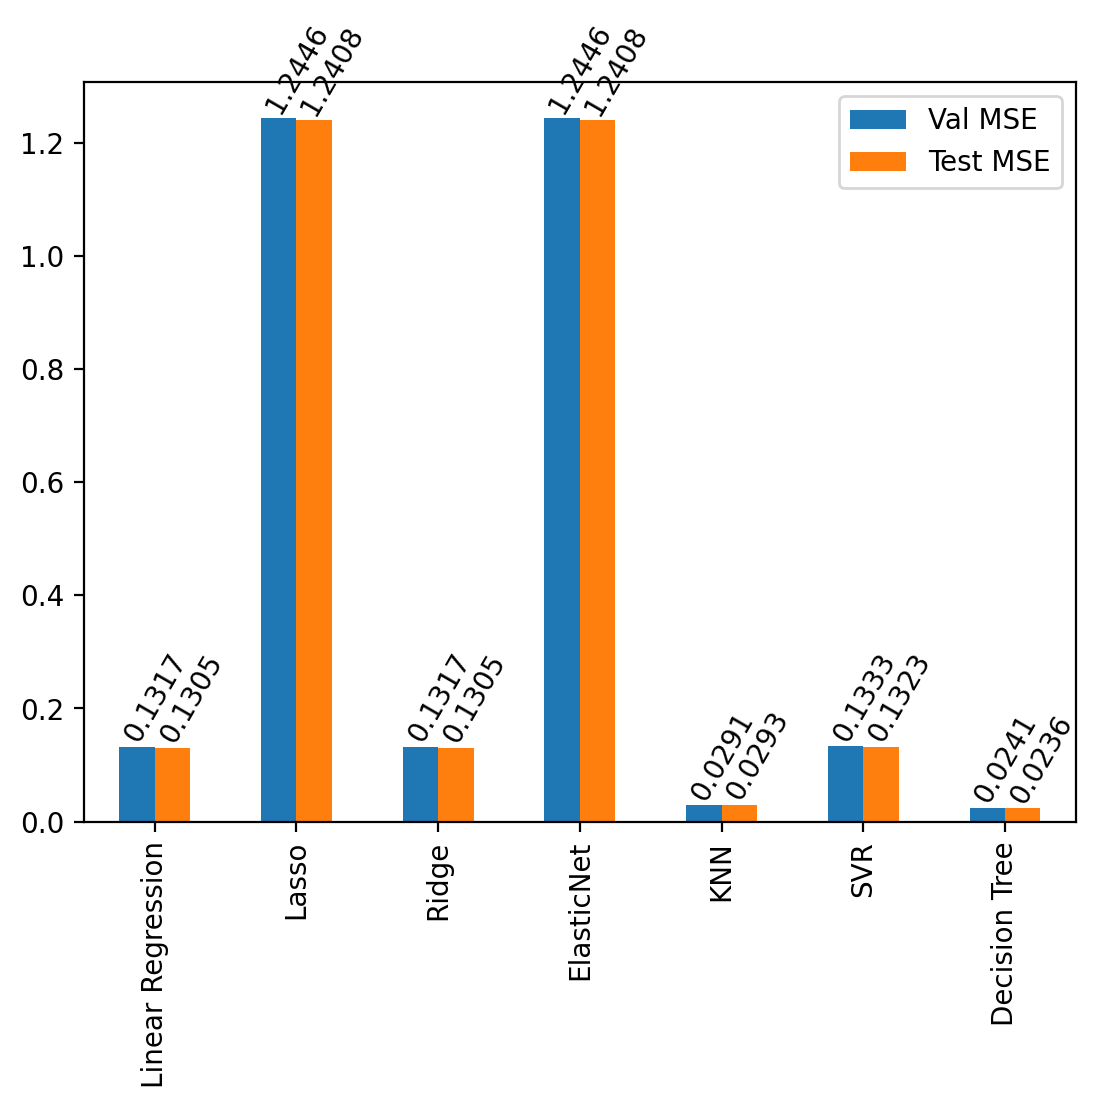

In [29]:
baseline_val_scores_df = pd.DataFrame(
  {
    "Val MSE": baseline_val_scores.values(),
    "Test MSE": baseline_test_scores.values()
  },
  index=baseline_val_scores.keys()
)

ax = baseline_val_scores_df.plot.bar()

for p in ax.patches:
    x = p.get_x()
    y = p.get_height() + 0.01
    label = f"{np.round(p.get_height(), 4):.4f}"

    ax.annotate(label, (x, y), ha='left', rotation=60)

plt.show()

In [30]:
pd.DataFrame(baseline_test_scores_actual).T.sort_values(by="R2", ascending=False)

,MAE,MAPE,MSE,RMSE,R2
Decision Tree,971.854086,0.060048,1.011210e+07,3179.952208,0.980390
KNN,1675.651454,0.096774,1.284559e+07,3584.074068,0.975089
SVR,4645.235731,0.296856,5.962084e+07,7721.453034,0.884381
Ridge,4958.470355,0.298171,7.089318e+07,8419.808889,0.862521
Linear Regression,4961.644599,0.298197,7.101008e+07,8426.747779,0.862295
Lasso,16635.811057,1.144278,6.085142e+08,24668.081326,-0.180054
ElasticNet,16635.811057,1.144278,6.085142e+08,24668.081326,-0.180054


## Ensemble Learning

In [31]:
ensemble_val_scores = dict()
ensemble_test_scores = dict()
ensemble_test_scores_actual = dict()

In [32]:
random_forest = RandomForestRegressor(n_jobs=-1)
random_forest.fit(X_train_scaled, y_train_scaled)

val_mse, test_mse, actual_scores = evaluate(random_forest)

ensemble_val_scores["Random Forest"] = val_mse
ensemble_test_scores["Random Forest"] = test_mse
ensemble_test_scores_actual["Random Forest"] = actual_scores

In [33]:
space = {
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "gamma": hp.uniform ("gamma", 1, 9),
    "reg_alpha": hp.quniform("reg_alpha", 40, 180, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree" : hp.uniform("colsample_bytree", 0.5, 1),
    "min_child_weight" : hp.quniform("min_child_weight", 0, 10, 1),
    "n_estimators": hp.quniform("n_estimators", 100, 100000, 1),
    "seed": 0
}

def objective(space):
    model = XGBRegressor(
        early_stopping_rounds=10,
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space["reg_alpha"]),
        reg_lambda=space["reg_lambda"],
        colsample_bytree=space["colsample_bytree"],
        min_child_weight=int(space["min_child_weight"]),
        n_estimators=int(space["n_estimators"])
    )

    model.fit(
        X_train_scaled,
        y_train_scaled,
        eval_set=[(X_val_scaled, y_val_scaled)],
        verbose=False
    )

    y_pred = model.predict(X_val_scaled)
    score = mean_squared_error(y_pred, y_val_scaled)

    return {'loss': score, 'status': STATUS_OK }

In [34]:
trials = Trials()

# best_hyperparams = fmin(
#     fn=objective,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=100,
#     trials=trials
# )

In [35]:
xgb_params = {
    "colsample_bytree": 0.8545834573974018,
    "gamma": 1.0149990564873104,
    "max_depth": 17,
    "min_child_weight": 8.0,
    "n_estimators": 5149,
    "reg_alpha": 40.0,
    "reg_lambda": 0.0008085443779402013
}

xgb = XGBRegressor(
    # **xgb_params,
    n_estimators=10000,
    early_stopping_rounds=25,
    n_jobs=-1
)

xgb.fit(
  X_train_scaled,
  y_train_scaled,
  eval_set=[(X_val_scaled, y_val_scaled)],
  verbose=250
)

val_mse, test_mse, actual_scores = evaluate(xgb)

ensemble_val_scores["XGBoost"] = val_mse
ensemble_test_scores["XGBoost"] = test_mse
ensemble_test_scores_actual["XGBoost"] = actual_scores

[0]	validation_0-rmse:6.24351
[250]	validation_0-rmse:0.15180
[500]	validation_0-rmse:0.13811
[750]	validation_0-rmse:0.13154
[1000]	validation_0-rmse:0.12748
[1250]	validation_0-rmse:0.12428
[1500]	validation_0-rmse:0.12243
[1750]	validation_0-rmse:0.12084
[2000]	validation_0-rmse:0.11944
[2250]	validation_0-rmse:0.11838
[2320]	validation_0-rmse:0.11824


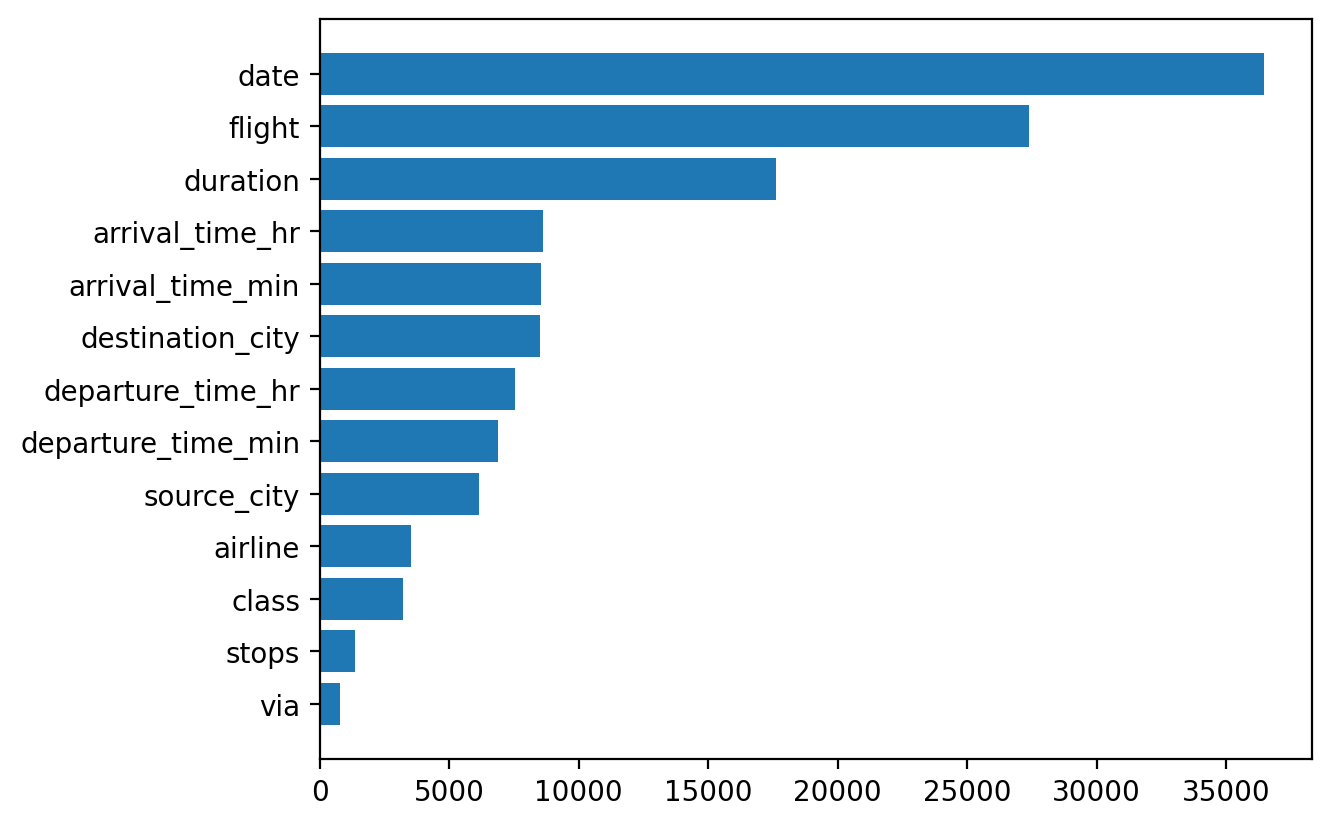

In [36]:
xgb_importance = xgb.get_booster().get_score(importance_type='weight')
xgb_importance_named = dict()

for i, weight in xgb_importance.items():
  xgb_importance_named[features[int(i[1:])]] = weight

xgb_importance_named = dict(sorted(xgb_importance_named.items(), key=lambda item: item[1]))

plt.barh(list(xgb_importance_named.keys()), xgb_importance_named.values())
plt.show()

In [37]:
lgb = LGBMRegressor(n_estimators=10000, early_stopping_round=25)
lgb.fit(
  X_train_scaled,
  y_train_scaled,
  eval_set=(X_val_scaled, y_val_scaled),
  callbacks=[log_evaluation(period=500)]
)

val_mse, test_mse, actual_scores = evaluate(lgb)

ensemble_val_scores["LightGBM"] = val_mse
ensemble_test_scores["LightGBM"] = test_mse
ensemble_test_scores_actual["LightGBM"] = actual_scores

[500]	valid_0's l2: 0.0261697
[1000]	valid_0's l2: 0.0209394
[1500]	valid_0's l2: 0.0183747
[2000]	valid_0's l2: 0.0168871
[2500]	valid_0's l2: 0.0159054
[3000]	valid_0's l2: 0.0152423
[3500]	valid_0's l2: 0.0147005
[4000]	valid_0's l2: 0.0142714
[4500]	valid_0's l2: 0.0139357
[5000]	valid_0's l2: 0.0136627
[5500]	valid_0's l2: 0.0134283
[6000]	valid_0's l2: 0.0132437


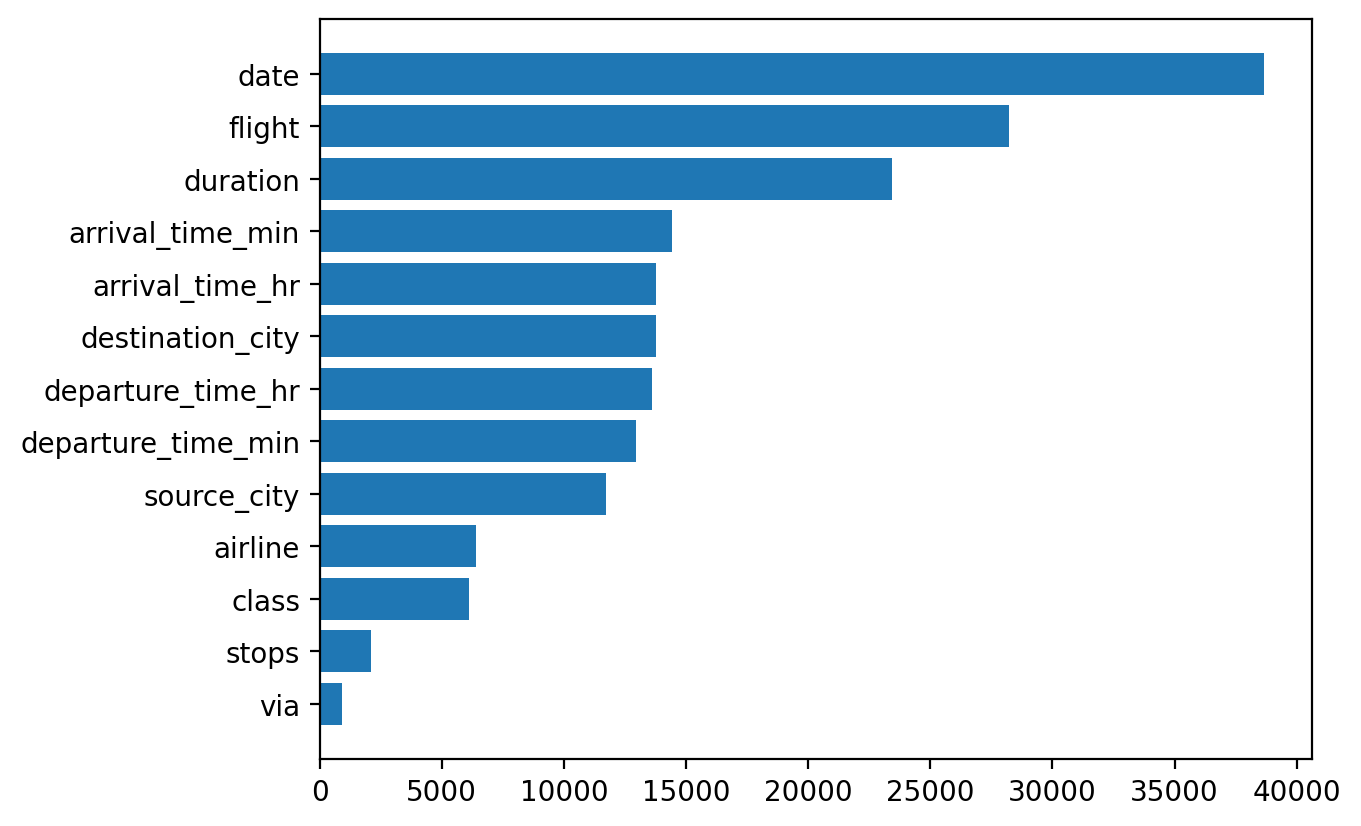

In [38]:
lgb_importance_named = dict()

for i, weight in enumerate(lgb.feature_importances_):
  if weight == 0:
    continue

  lgb_importance_named[features[i]] = weight

lgb_importance_named = dict(sorted(lgb_importance_named.items(), key=lambda item: item[1]))

plt.barh(list(lgb_importance_named.keys()), lgb_importance_named.values())
plt.show()

In [39]:
catb = CatBoostRegressor(n_estimators=10000, early_stopping_rounds=25)
catb.fit(
  X_train_scaled,
  y_train_scaled,
  eval_set=(X_val_scaled, y_val_scaled),
  metric_period=500
)

val_mse, test_mse, actual_scores = evaluate(catb)

ensemble_val_scores["CatBoost"] = val_mse
ensemble_test_scores["CatBoost"] = test_mse
ensemble_test_scores_actual["CatBoost"] = actual_scores

Learning rate set to 0.028778


0:	learn: 1.0822675	test: 1.0857772	best: 1.0857772 (0)	total: 231ms	remaining: 38m 29s
500:	learn: 0.2197077	test: 0.2190687	best: 0.2190687 (500)	total: 11s	remaining: 3m 27s
1000:	learn: 0.2017469	test: 0.2016598	best: 0.2016598 (1000)	total: 21.9s	remaining: 3m 17s
1500:	learn: 0.1916920	test: 0.1921065	best: 0.1921065 (1500)	total: 32.3s	remaining: 3m 2s
2000:	learn: 0.1843800	test: 0.1853108	best: 0.1853108 (2000)	total: 42.4s	remaining: 2m 49s
2500:	learn: 0.1786492	test: 0.1800596	best: 0.1800596 (2500)	total: 52.6s	remaining: 2m 37s
3000:	learn: 0.1740277	test: 0.1760930	best: 0.1760930 (3000)	total: 1m 2s	remaining: 2m 26s
3500:	learn: 0.1703602	test: 0.1729092	best: 0.1729092 (3500)	total: 1m 12s	remaining: 2m 15s
4000:	learn: 0.1671115	test: 0.1701145	best: 0.1701145 (4000)	total: 1m 22s	remaining: 2m 4s
4500:	learn: 0.1641479	test: 0.1675848	best: 0.1675848 (4500)	total: 1m 32s	remaining: 1m 53s
5000:	learn: 0.1615796	test: 0.1654250	best: 0.1654250 (5000)	total: 1m 42s	re

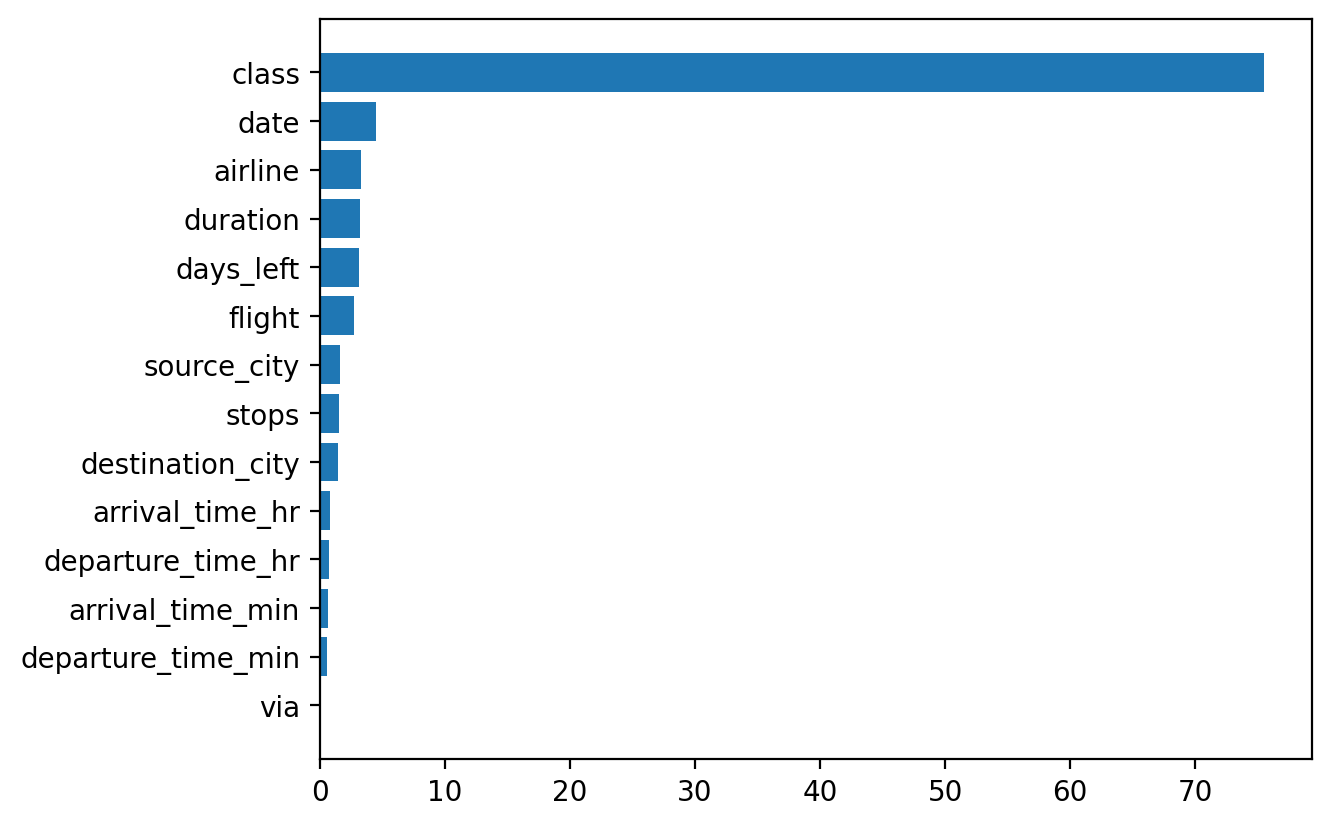

In [40]:
catb_importance_named = dict()

for i, weight in enumerate(catb.feature_importances_):
  catb_importance_named[features[i]] = weight

catb_importance_named = dict(sorted(catb_importance_named.items(), key=lambda item: item[1]))

plt.barh(list(catb_importance_named.keys()), catb_importance_named.values())
plt.show()

### Summary

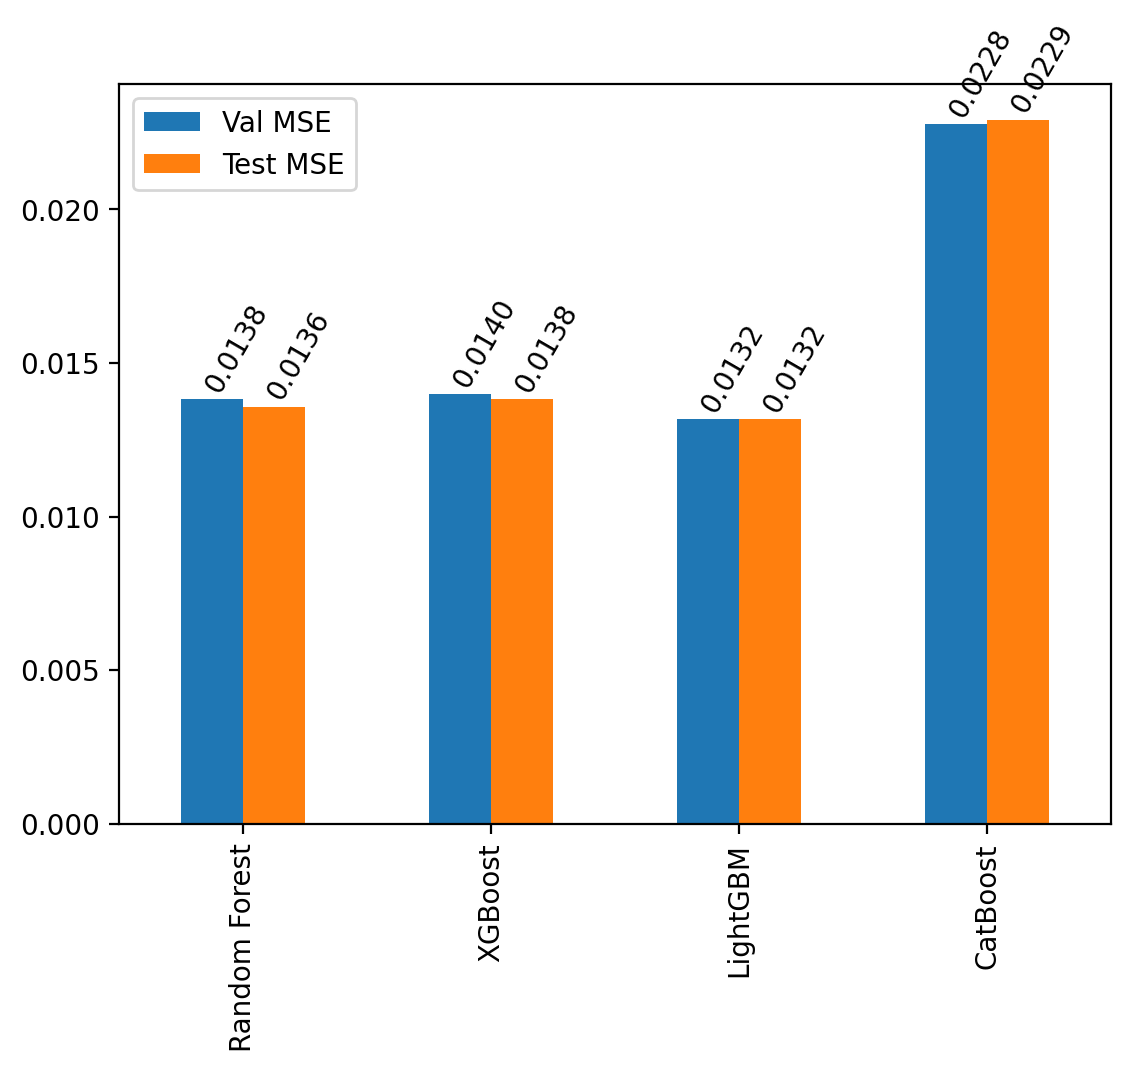

In [41]:
ensemble_val_scores_df = pd.DataFrame(
  {
    "Val MSE": ensemble_val_scores.values(),
    "Test MSE": ensemble_test_scores.values()
  },
  index=ensemble_val_scores.keys()
)

ax = ensemble_val_scores_df.plot.bar()

for p in ax.patches:
    x = p.get_x() + 0.075
    y = p.get_height() + 0.00025
    label = f"{np.round(p.get_height(), 4):.4f}"

    ax.annotate(label, (x, y), ha='left', rotation=60)

plt.show()

In [42]:
pd.DataFrame(ensemble_test_scores_actual).T.sort_values(by="R2", ascending=False)

,MAE,MAPE,MSE,RMSE,R2
Random Forest,891.596880,0.053464,5.770398e+06,2402.165307,0.988810
LightGBM,1162.994600,0.066645,6.175107e+06,2484.976163,0.988025
XGBoost,1358.010427,0.071498,7.936230e+06,2817.131498,0.984610
CatBoost,1644.390318,0.099001,1.016727e+07,3188.616397,0.980283


## Neural Networks

In [43]:
nn_val_scores = dict()
nn_test_scores = dict()
nn_test_scores_actual = dict()

In [44]:
mlp_256 = Sequential()

mlp_256.add(Input(shape=(14,)))

mlp_256.add(Dense(256, activation="relu"))
mlp_256.add(Dropout(0.2))

mlp_256.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_256.compile(loss="mean_squared_error", optimizer=opt)

In [45]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_256_hist = mlp_256.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# model.save("artifacts/mlp_256.h5")

# with open('logs/mlp_256.json', "w") as f:
#     f.write(json.dumps(mlp_256_hist.history))

In [46]:
mlp_256 = keras.models.load_model("artifacts/mlp_256.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_256)

nn_val_scores["MLP 256"] = val_mse
nn_test_scores["MLP 256"] = test_mse
nn_test_scores_actual["MLP 256"] = actual_scores

2346/2346 [==============================] - 3s 1ms/step


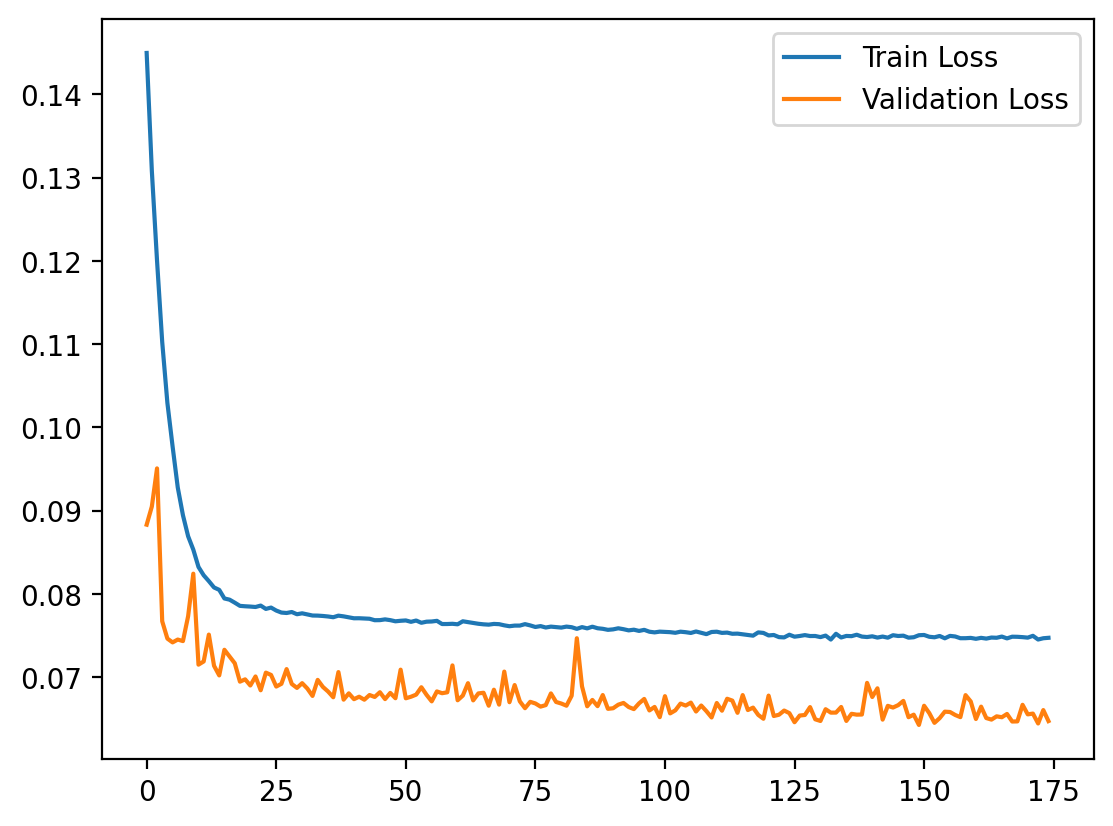

In [47]:
with open("logs/mlp_256.json", "r") as f:
  mlp_256_hist = json.loads(f.read())

plt.plot(mlp_256_hist["loss"])
plt.plot(mlp_256_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

In [48]:
mlp_128_64_32 = Sequential()

mlp_128_64_32.add(Input(shape=(14,)))

mlp_128_64_32.add(Dense(128, activation="relu"))
mlp_128_64_32.add(Dropout(0.2))

mlp_128_64_32.add(Dense(64, activation="relu"))
mlp_128_64_32.add(Dropout(0.2))

mlp_128_64_32.add(Dense(32, activation="relu"))
mlp_128_64_32.add(Dropout(0.2))

mlp_128_64_32.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_128_64_32.compile(loss="mean_squared_error", optimizer=opt)

In [49]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_128_64_32_hist = mlp_128_64_32.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# model.save("artifacts/mlp_128_64_32.h5")

# with open('logs/mlp_128_64_32.json', "w") as f:
#     f.write(json.dumps(mlp_128_64_32_hist.history))

In [50]:
mlp_128_64_32 = keras.models.load_model("artifacts/mlp_128_64_32.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_128_64_32)

nn_val_scores["MLP 128x64x32"] = val_mse
nn_test_scores["MLP 128x64x32"] = test_mse
nn_test_scores_actual["MLP 128x64x32"] = actual_scores

2346/2346 [==============================] - 3s 1ms/step


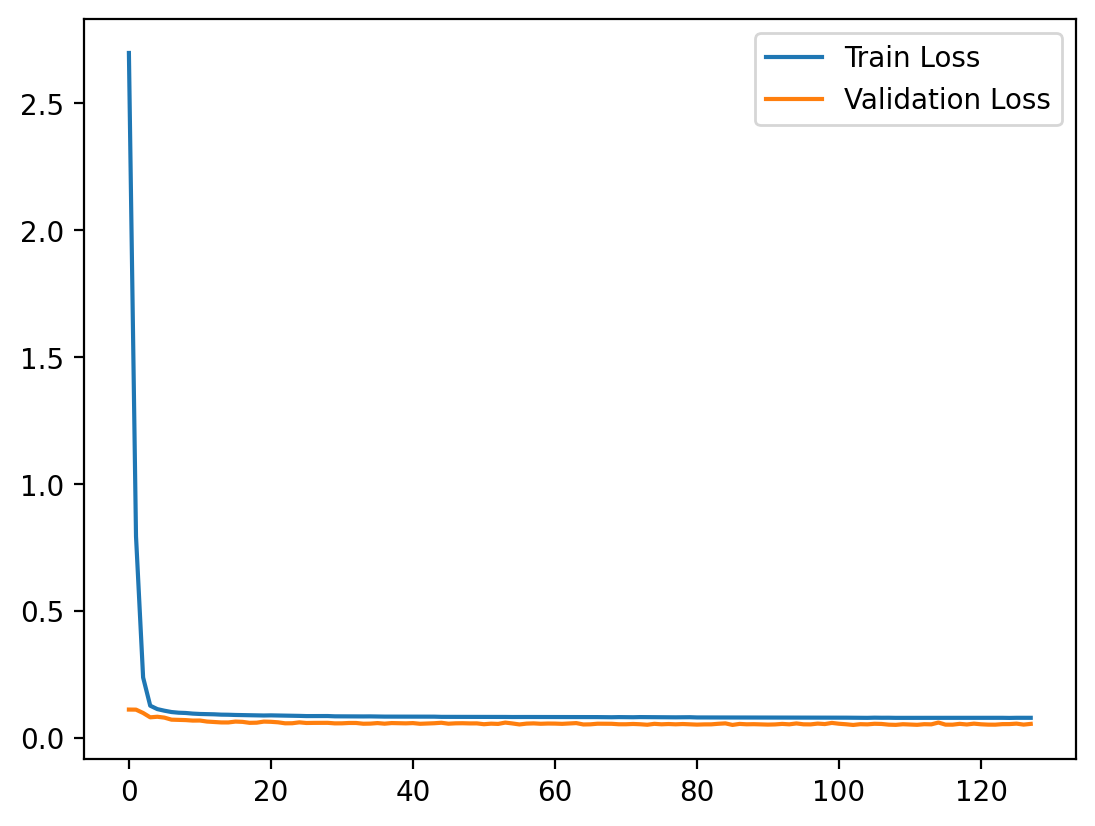

In [51]:
with open("logs/mlp_128_64_32.json", "r") as f:
  mlp_128_64_32_hist = json.loads(f.read())

plt.plot(mlp_128_64_32_hist["loss"])
plt.plot(mlp_128_64_32_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

In [52]:
mlp_256_128_64 = Sequential()

mlp_256_128_64.add(Input(shape=(14,)))

mlp_256_128_64.add(Dense(256, activation="relu"))
mlp_256_128_64.add(Dropout(0.2))

mlp_256_128_64.add(Dense(128, activation="relu"))
mlp_256_128_64.add(Dropout(0.2))

mlp_256_128_64.add(Dense(64, activation="relu"))
mlp_256_128_64.add(Dropout(0.2))

mlp_256_128_64.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_256_128_64.compile(loss="mean_squared_error", optimizer=opt)

In [53]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_256_128_64_hist = mlp_256_128_64.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# mlp_256_128_64.save("artifacts/mlp_256_128_64.h5")

# with open('logs/mlp_256_128_64.json', "w") as f:
#     f.write(json.dumps(mlp_256_128_64_hist.history))

In [54]:
mlp_256_128_64 = keras.models.load_model("artifacts/mlp_256_128_64.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_256_128_64)

nn_val_scores["MLP 256x128x64"] = val_mse
nn_test_scores["MLP 256x128x64"] = test_mse
nn_test_scores_actual["MLP 256x128x64"] = actual_scores

2346/2346 [==============================] - 3s 1ms/step


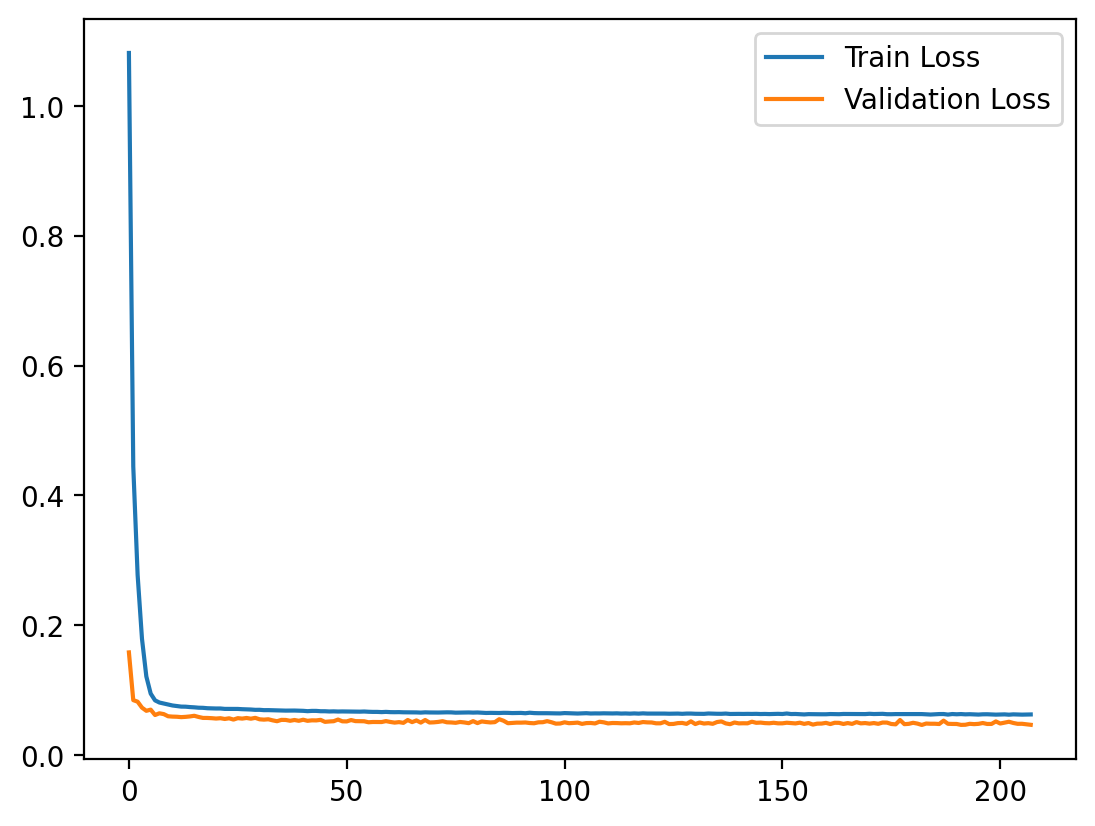

In [55]:
with open("logs/mlp_256_128_64.json", "r") as f:
  mlp_256_128_64_hist = json.loads(f.read())

plt.plot(mlp_256_128_64_hist["loss"])
plt.plot(mlp_256_128_64_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

### Summary

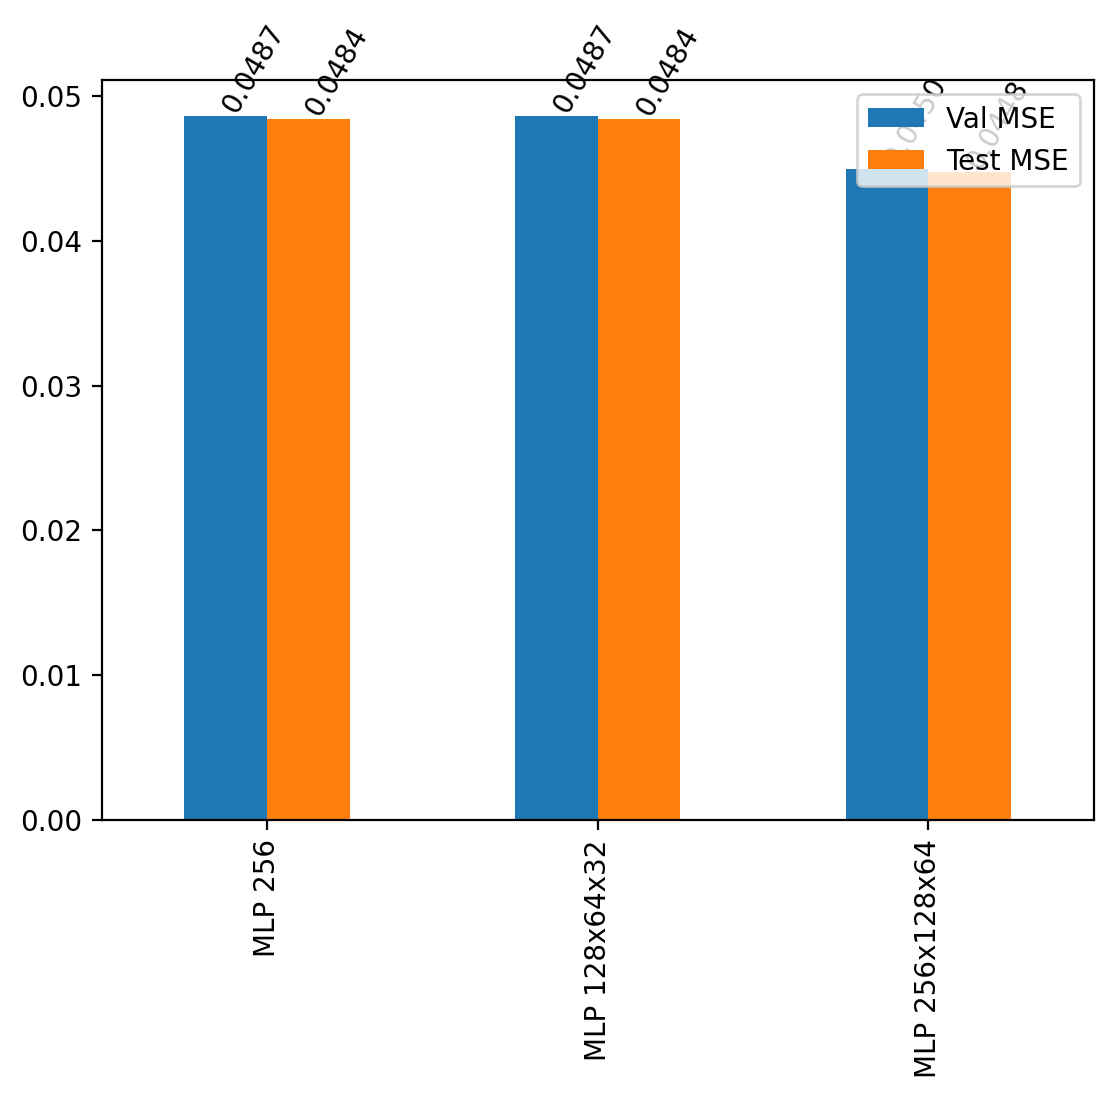

In [56]:
nn_val_scores_df = pd.DataFrame(
  {
    "Val MSE": nn_val_scores.values(),
    "Test MSE": nn_test_scores.values()
  },
  index=nn_val_scores.keys()
)

ax = nn_val_scores_df.plot.bar()

for p in ax.patches:
    x = p.get_x() + 0.1
    y = p.get_height() + 0.00025
    label = f"{np.round(p.get_height(), 4):.4f}"

    ax.annotate(label, (x, y), ha='left', rotation=60)

plt.show()

In [57]:
pd.DataFrame(nn_test_scores_actual).T.sort_values(by="R2", ascending=False)

,MAE,MAPE,MSE,RMSE,R2
MLP 256,2580.471866,0.159851,2.150178e+07,4637.000816,0.958303
MLP 128x64x32,2580.471866,0.159851,2.150178e+07,4637.000816,0.958303
MLP 256x128x64,2587.820108,0.151108,2.253498e+07,4747.102402,0.956299


# Evaluation

In [58]:
y_pred = np.expm1(lgb.predict(X_test_scaled))
y_pred_series = pd.Series(y_pred, index=X_test.index, name="predicted_price")

In [59]:
predicted_df = pd.concat([X_test, y_test, y_pred_series], axis=1)
predicted_df["deviation"] = predicted_df["predicted_price"] - predicted_df["price"]
predicted_df.head()

,date,airline,ch_code,num_code,departure_time,source_city,time_taken,stop,arrival_time,destination_city,...,departure_time_min,arrival_time_hr,arrival_time_min,duration,stops,via,class,price,predicted_price,deviation
50339,2022-03-20,AirAsia,I5,942,13:05,Mumbai,14h 15m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,03:20,Delhi,...,5,3,20,855.0,1-stop,UNK,Economy,2336,2594.668800,258.668800
127073,2022-03-29,AirAsia,I5,2991,21:35,Kolkata,11h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,08:55,Delhi,...,35,8,55,680.0,1-stop,UNK,Economy,3014,3099.204363,85.204363
14907,2022-03-08,AirAsia,I5,710,11:55,Delhi,07h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:20,Bangalore,...,55,19,20,445.0,1-stop,UNK,Economy,3090,2822.937307,-267.062693
61128,2022-02-20,Air India,AI,732,13:00,Kolkata,29h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia PAT\n\t\t\...,18:30,Bangalore,...,0,18,30,1770.0,1-stop,PAT,Business,52287,52702.378015,415.378015
46286,2022-03-01,AirAsia,I5,942,13:05,Mumbai,12h 15m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,01:20,Delhi,...,5,1,20,735.0,1-stop,UNK,Economy,2336,2296.727160,-39.272840


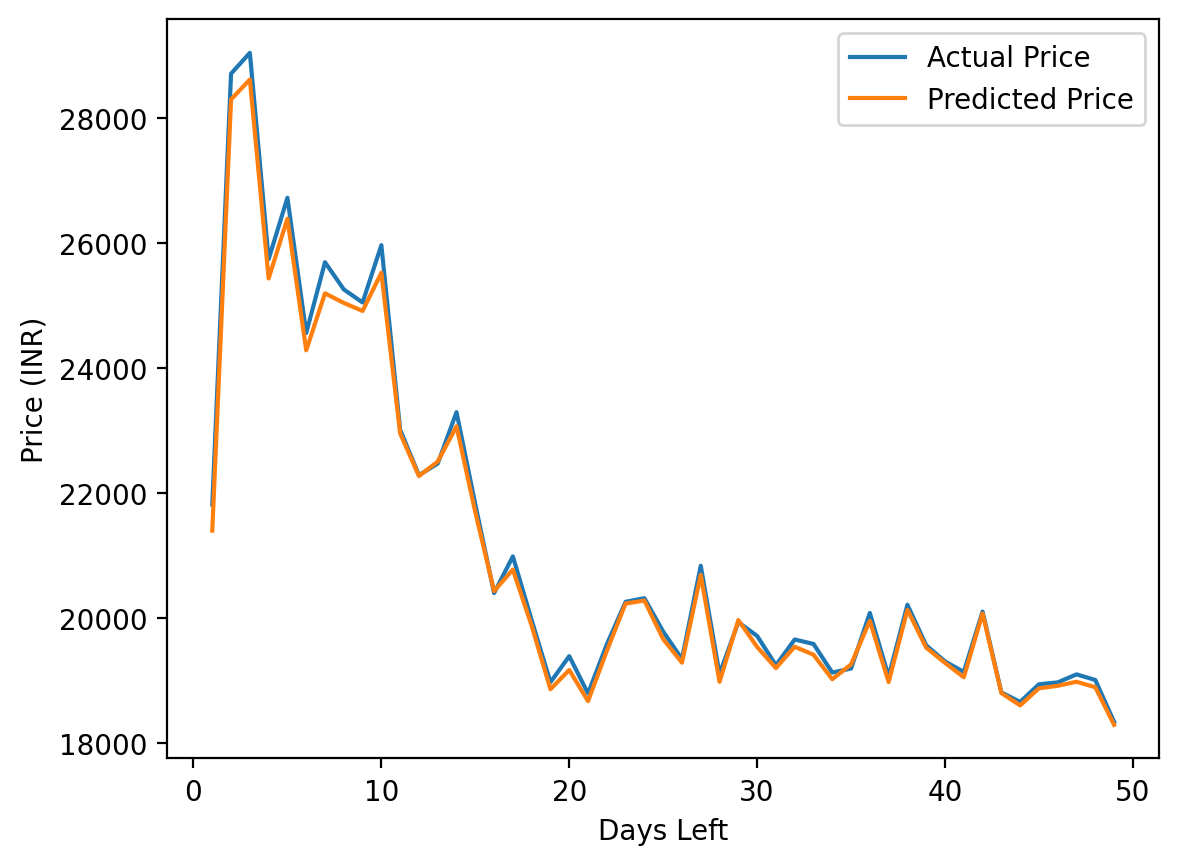

In [60]:
prices_by_days_left = predicted_df[["days_left", "price", "predicted_price"]].groupby("days_left").mean()

plt.plot(prices_by_days_left.index, prices_by_days_left["price"])
plt.plot(prices_by_days_left.index, prices_by_days_left["predicted_price"])

plt.xlabel("Days Left")
plt.ylabel("Price (INR)")
plt.legend(["Actual Price", "Predicted Price"])

plt.show()

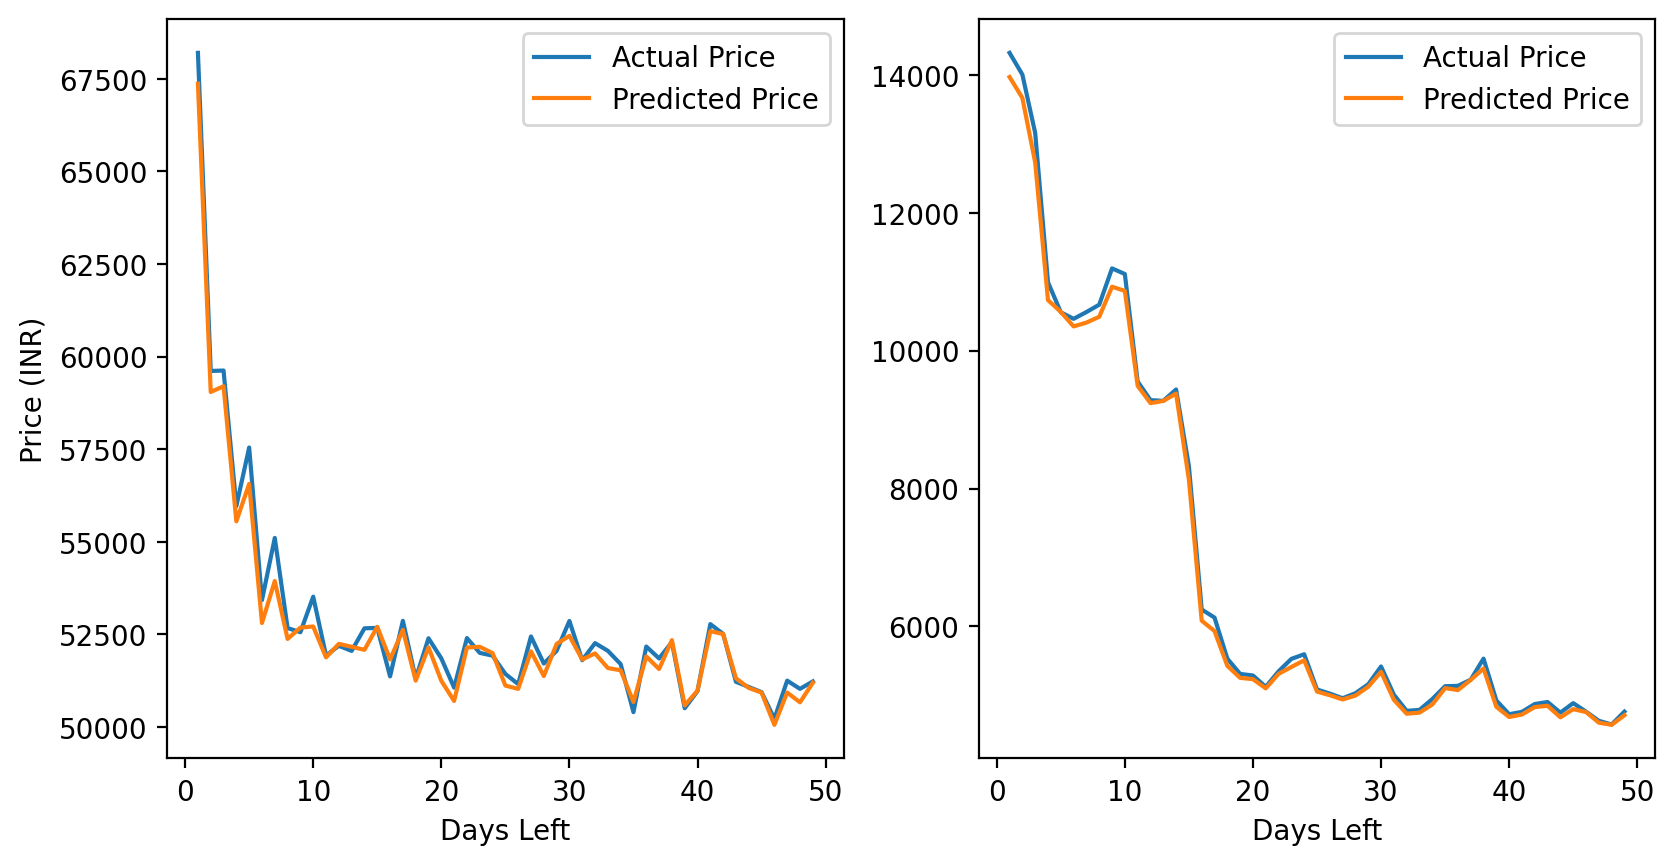

In [61]:
prices_by_days_left = predicted_df[["class", "days_left", "price", "predicted_price"]].groupby(["class", "days_left"]).mean()

plt.figure(figsize=(9.6, 4.8))
plt.subplot(1, 2, 1)
plt.plot(prices_by_days_left.loc["Business"].index, prices_by_days_left.loc["Business"]["price"])
plt.plot(prices_by_days_left.loc["Business"].index, prices_by_days_left.loc["Business"]["predicted_price"])

plt.xlabel("Days Left")
plt.ylabel("Price (INR)")
plt.legend(["Actual Price", "Predicted Price"])

plt.subplot(1, 2, 2)
plt.plot(prices_by_days_left.loc["Economy"].index, prices_by_days_left.loc["Economy"]["price"])
plt.plot(prices_by_days_left.loc["Economy"].index, prices_by_days_left.loc["Economy"]["predicted_price"])

plt.xlabel("Days Left")
plt.legend(["Actual Price", "Predicted Price"])

plt.show()

## Error Distribution

In [62]:
predicted_df["deviation"].describe()

count    75066.000000
mean      -123.622734
std       2481.915795
min     -43825.610347
25%       -326.933473
50%         37.919838
75%        453.117936
max      27799.688305
Name: deviation, dtype: float64

In [63]:
print(predicted_df["deviation"].quantile(0.9))
print(predicted_df["deviation"].quantile(0.95))
print(predicted_df["deviation"].quantile(0.99))

1552.419502445835
2684.225184068013
6023.599083987149


In [64]:
predicted_df[["class", "deviation"]].groupby("class").describe()

deviation                                                       
             count        mean          std           min          25%   
class                                                                    
Business   23482.0 -204.968150  4089.281752 -43825.610347 -1141.316768  \
Economy    51584.0  -86.592782  1160.856805 -19672.998465  -201.871532   

                                                 
                 50%          75%           max  
class                                            
Business  286.180293  1657.757019  27799.688305  
Economy    21.818097   256.347204  10558.575311

In [65]:
print(predicted_df[["class", "deviation"]].groupby("class").quantile(0.9))
print(predicted_df[["class", "deviation"]].groupby("class").quantile(0.95))
print(predicted_df[["class", "deviation"]].groupby("class").quantile(0.99))

            deviation
class                
Business  3361.160706
Economy    652.323556
            deviation
class                
Business  4760.908682
Economy   1053.106298
            deviation
class                
Business  8652.020182
Economy   2374.674074
